  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Antes del balanceo: {0: 358, 1: 32}
Después del balanceo: {0: 358, 1: 358}

*** Modelo: Random Forest (con RandomOverSampler) ***



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Mejor umbral para F1: 0.58
              precision    recall  f1-score   support

           0      0.928     0.975     0.951       119
           1      0.400     0.182     0.250        11

    accuracy                          0.908       130
   macro avg      0.664     0.578     0.600       130
weighted avg      0.883     0.908     0.892       130

Matriz de confusión:
 [[116   3]
 [  9   2]]
ROC-AUC: 0.547746371275783


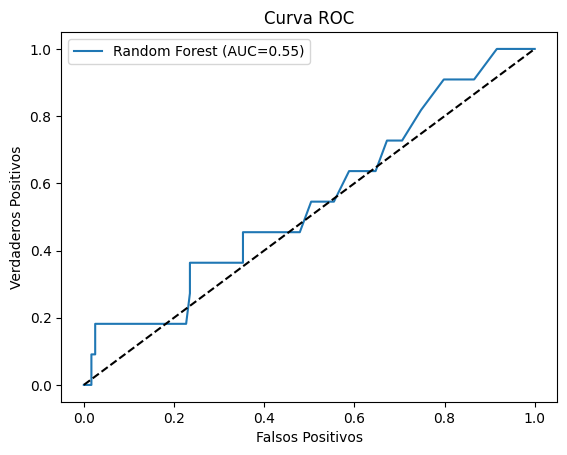


*** Modelo: XGBoost (con RandomOverSampler) ***


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:41:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor umbral para F1: 0.38
              precision    recall  f1-score   support

           0      0.933     0.941     0.937       119
           1      0.300     0.273     0.286        11

    accuracy                          0.885       130
   macro avg      0.617     0.607     0.611       130
weighted avg      0.880     0.885     0.882       130

Matriz de confusión:
 [[112   7]
 [  8   3]]
ROC-AUC: 0.7303284950343774


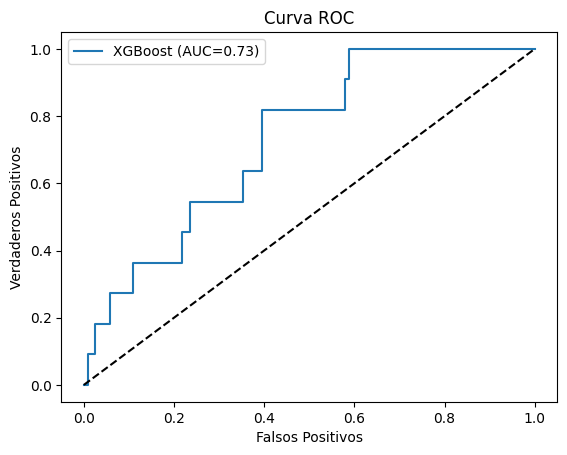

In [ ]:
%pip install xgboost
!pip install imbalanced-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Opcional: si tiene XGBoost
from xgboost import XGBClassifier

# 1. Cargar y preparar datos
df = pd.read_csv('AccidentesElectricos_Limpio (1).csv')
df['GRAVE'] = (df['TIPO_LESION'].str.lower() == 'muerte').astype(int)
vars_objetivo = [
    'TIPO_VINCULACION', 'EDAD', 'TIEMPO_VINCULACION', 'UBICACION',
    'CAUSA_ACCIDENTE', 'SEXO', 'GRADO_ESCOLARIDAD', 'SECCION_EMPRESA'
]
df = df.dropna(subset=vars_objetivo + ['TIPO_LESION'])
for col in ['TIPO_VINCULACION', 'UBICACION', 'CAUSA_ACCIDENTE', 'SEXO', 'GRADO_ESCOLARIDAD', 'SECCION_EMPRESA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X = df[vars_objetivo]
y = df['GRAVE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train[['EDAD', 'TIEMPO_VINCULACION']] = scaler.fit_transform(X_train[['EDAD', 'TIEMPO_VINCULACION']])
X_test[['EDAD', 'TIEMPO_VINCULACION']] = scaler.transform(X_test[['EDAD', 'TIEMPO_VINCULACION']])

# 2. Balanceo con RandomOverSampler (sólo en entrenamiento)
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print(f"Antes del balanceo: {y_train.value_counts().to_dict()}")
print(f"Después del balanceo: {pd.Series(y_train_ros).value_counts().to_dict()}")

# 3. Modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, sc
    ale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for nombre, modelo in modelos.items():
    print(f'\n*** Modelo: {nombre} (con RandomOverSampler) ***')
    modelo.fit(X_train_ros, y_train_ros)
    y_prob = modelo.predict_proba(X_test)[:,1]

    # Encontrar el umbral óptimo para F1 en la clase 1
    best_f1 = 0
    best_thresh = 0.5
    for thresh in [i/100 for i in range(30, 80, 2)]:  # prueba de 0.30 a 0.78
        y_pred_thresh = (y_prob >= thresh).astype(int)
        f1 = classification_report(y_test, y_pred_thresh, output_dict=True)['1']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    # Resultados con el mejor umbral
    y_pred_opt = (y_prob >= best_thresh).astype(int)
    print(f'Mejor umbral para F1: {best_thresh:.2f}')
    print(classification_report(y_test, y_pred_opt, digits=3))
    print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_opt))
    print('ROC-AUC:', roc_auc_score(y_test, y_prob))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre} (AUC={roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Falsos Positivos')
    plt.ylabel('Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [2]:
print("Resumen estadístico antes del balanceo:")
print(X_train.describe())
print("\nDistribución de la variable objetivo antes del balanceo:")
print(y_train.value_counts())

Resumen estadístico antes del balanceo:
       TIPO_VINCULACION          EDAD  TIEMPO_VINCULACION   UBICACION  \
count        390.000000  3.900000e+02        3.900000e+02  390.000000   
mean           2.012821 -9.109522e-18       -2.732857e-17    1.484615   
std            1.037765  1.001285e+00        1.001285e+00    0.567789   
min            1.000000 -3.017128e+00       -5.852072e-01    0.000000   
25%            1.000000 -6.664546e-01       -5.314755e-01    1.000000   
50%            1.500000 -7.878630e-02       -4.025194e-01    2.000000   
75%            3.000000  6.767872e-01       -6.938280e-02    2.000000   
max            4.000000  5.210228e+00        7.399325e+00    2.000000   

       CAUSA_ACCIDENTE        SEXO  GRADO_ESCOLARIDAD  SECCION_EMPRESA  
count       390.000000  390.000000         390.000000       390.000000  
mean          3.512821    0.989744           4.007692         2.800000  
std           2.859807    0.100883           2.646712         2.761468  
min       

In [3]:
print("\nMatriz de correlación antes del balanceo:")
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
print(corr_matrix)


Matriz de correlación antes del balanceo:
                    TIPO_VINCULACION      EDAD  TIEMPO_VINCULACION  UBICACION  \
TIPO_VINCULACION            1.000000  0.057803            0.397003   0.098498   
EDAD                        0.057803  1.000000            0.378353   0.008971   
TIEMPO_VINCULACION          0.397003  0.378353            1.000000   0.024624   
UBICACION                   0.098498  0.008971            0.024624   1.000000   
CAUSA_ACCIDENTE             0.287954 -0.130440           -0.052611   0.167937   
SEXO                       -0.023295  0.119120            0.039608   0.042118   
GRADO_ESCOLARIDAD          -0.101117 -0.050802           -0.010042  -0.081176   
SECCION_EMPRESA             0.139041 -0.222746           -0.035522   0.140673   
GRAVE                      -0.111872 -0.005515           -0.077371   0.074016   

                    CAUSA_ACCIDENTE      SEXO  GRADO_ESCOLARIDAD  \
TIPO_VINCULACION           0.287954 -0.023295          -0.101117   
EDAD      

In [4]:
print("\nResumen estadístico después del balanceo:")
print(pd.DataFrame(X_train_ros, columns=X_train.columns).describe())
print("\nDistribución de la variable objetivo después del balanceo:")
print(pd.Series(y_train_ros).value_counts())

# Matriz de correlación después del balanceo
print("\nMatriz de correlación después del balanceo:")
corr_matrix_ros = pd.concat(
    [pd.DataFrame(X_train_ros, columns=X_train.columns), pd.Series(y_train_ros, name='GRAVE')],
    axis=1
).corr()
print(corr_matrix_ros)


Resumen estadístico después del balanceo:
       TIPO_VINCULACION        EDAD  TIEMPO_VINCULACION   UBICACION  \
count        716.000000  716.000000          716.000000  716.000000   
mean           1.858939   -0.067530           -0.119753    1.560056   
std            1.031499    1.091204            0.832571    0.577452   
min            1.000000   -3.017128           -0.585207    0.000000   
25%            1.000000   -0.582502           -0.542222    1.000000   
50%            1.000000   -0.162739           -0.445505    2.000000   
75%            3.000000    0.592835           -0.198339    2.000000   
max            4.000000    5.210228            7.399325    2.000000   

       CAUSA_ACCIDENTE        SEXO  GRADO_ESCOLARIDAD  SECCION_EMPRESA  
count       716.000000  716.000000         716.000000       716.000000  
mean          2.998603    0.977654           3.884078         2.949721  
std           2.454338    0.147911           2.619822         2.960861  
min           0.000000   

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13068\3291728028.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GRAVE', data=df, palette='Set2')


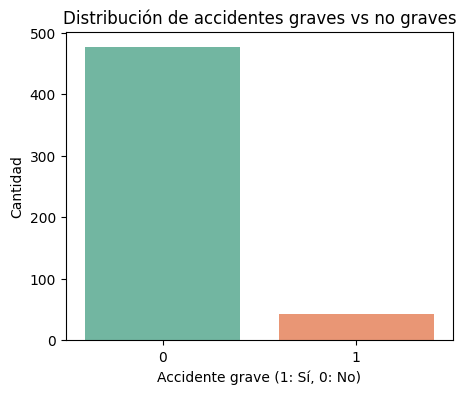

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x='GRAVE', data=df, palette='Set2')
plt.title("Distribución de accidentes graves vs no graves")
plt.xlabel("Accidente grave (1: Sí, 0: No)")
plt.ylabel("Cantidad")
plt.show()

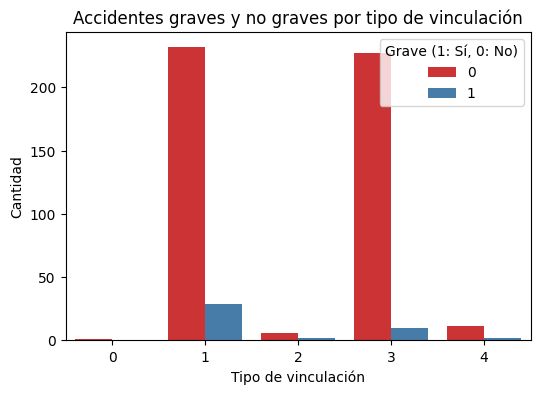

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='TIPO_VINCULACION', hue='GRAVE', data=df, palette='Set1')
plt.title("Accidentes graves y no graves por tipo de vinculación")
plt.xlabel("Tipo de vinculación")
plt.ylabel("Cantidad")
plt.legend(title="Grave (1: Sí, 0: No)")
plt.show()

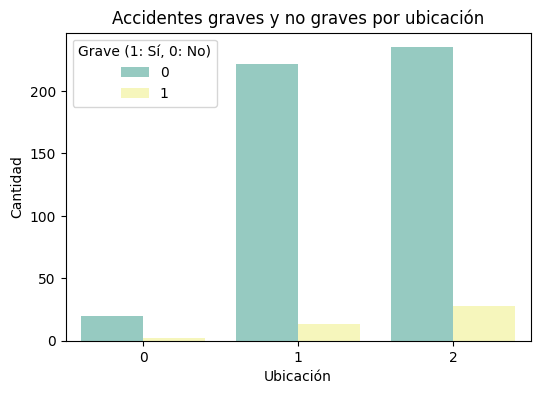

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='UBICACION', hue='GRAVE', data=df, palette='Set3')
plt.title("Accidentes graves y no graves por ubicación")
plt.xlabel("Ubicación")
plt.ylabel("Cantidad")
plt.legend(title="Grave (1: Sí, 0: No)")
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13068\200261385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GRAVE', y='EDAD', data=df, palette='Set2')


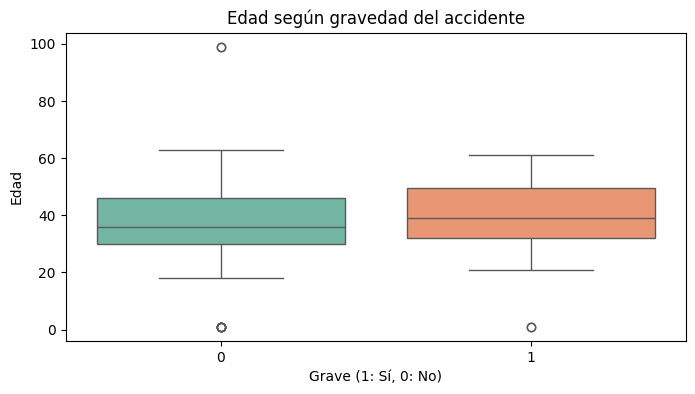

In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(x='GRAVE', y='EDAD', data=df, palette='Set2')
plt.title("Edad según gravedad del accidente")
plt.xlabel("Grave (1: Sí, 0: No)")
plt.ylabel("Edad")
plt.show()

